In [21]:
import matplotlib.pyplot as plt
import pandas as pd #this is how I usually import pandas
import sys #only needed to determine Python version number
import matplotlib #only needed to determine Matplotlib version number
import glob
import numpy as np
import os, glob
import csv
import operator


def buildDataFrame(filePath, colNames, dropCols, numericCols, quant):
    df_temp = pd.read_csv(filePath,names=colNames)
    for colName in dropCols:
        df_temp = df_temp.drop(colName, 1)
    df_temp = df_temp[numericCols].apply(pd.to_numeric,errors='coerce')
    df_temp = df_temp.dropna()
    df_temp = df_temp.sort_values(by='start_ts', ascending=[True])
    if quant != 0:
        df_temp = df_temp[df_temp.start_ts > df_temp.start_ts.quantile(quant)]
    return df_temp

#['geo','latency','mx','mn','wc','start_ts']
def pruneForDenseWindows(dataframe,percentage):
    pd.to_numeric(dataframe.wc)
    topWindows = dataframe.wc.quantile(percentage)
    #print(topWindows)
    dataframe = dataframe[dataframe.wc > topWindows  ]
    return dataframe


def pandasDraw(listOfFilePaths,_figsize,_range, colNames, dropCols, numericCols, quant, isLatency):
    for fileGroup in listOfFilePaths:
        df_list = []
        for file in fileGroup:
            column_name = file.rsplit('.', 1)[0]
            temp_df = buildDataFrame(file, colNames, dropCols, numericCols, quant)
            if(isLatency):
                temp_df_with_cols = pd.DataFrame({column_name:temp_df.latency},
                    columns=[column_name])
                df_list.append(temp_df_with_cols)
            else:
                temp_df_with_cols = pd.DataFrame({column_name:temp_df.its},
                    columns=[column_name])
                df_list.append(temp_df_with_cols)
        df_final = pd.concat(df_list)
        ax_df_final = df_final.hist(figsize=_figsize,bins=100,range=_range)
    plt.show()
    


def dataGeneratorStats(path,_figsize):
    d = {}
    fileCount = 0
    for filePath in glob.glob(path + '*'):
        fileCount = fileCount + 1
        reader = csv.reader(open(filePath, 'r'))
        for row in reader:
            k , v = row
            v = int(v) , 1
            k = int(k)
            if k in d:
                d[k]  = tuple(map(operator.add, d[k], v))
            else:
                d[k] = v
    finalD = {}
    for k, v in d.items():
        if v[1] == fileCount:
            finalD[k] = v[0]
    df = pd.DataFrame(list(finalD.items()),columns=['ts', 'count'])
    df = df.sort_values(by='ts', ascending=[True])
    df.plot.bar(y='count', x = 'ts',figsize=_figsize,)
    plt.show()

def dataGeneratorStatsSeparate(path,_figsize,_xlabel,_ylabel,_xticks):
    df_list = []
    for filePath in glob.glob(path + '*'):
        d = {}
        reader = csv.reader(open(filePath, 'r'))
        for row in reader:
            k , v = row
            v = int(v) 
            k = int(k)
            d[k] = v
        #print( [int(i[1]) for i in d.items()] )
        df = pd.DataFrame({'ts':[int(i[0]) for i in d.items()] , 'count': [int(i[1]) for i in d.items()]},columns=['ts', 'count'])
        df = df.sort_values(by='ts', ascending=[True])
        minEl = df.ts.iloc[0]
        df['ts'] = df['ts'] - minEl
        df_list.append(df)
        ax=df.plot(y='count', x = 'ts',figsize=_figsize, xticks = np.arange(df.ts.min(),  df.ts.max(), _xticks) ,marker='x')
        ax.set_xlabel(_xlabel)
        ax.set_ylabel(_ylabel)

    #df_final = pd.concat(df_list)
    #ax_df_final = df_final.plot.bar(y='count', x = 'ts',figsize=_figsize)
    plt.show()

def dataGeneratorStatsSeparateOneAxis(path,_figsize,_xlabel,_ylabel,_xticks):
    for filePath in glob.glob(path + '*'):
        d = {}
        reader = csv.reader(open(filePath, 'r'))
        for row in reader:
            k , v = row
            v = int(v) 
            k = int(k)
            d[k] = v
        #print( [int(i[1]) for i in d.items()] )
        df = pd.DataFrame({'ts':[int(i[0]) for i in d.items()] },columns=['ts'])
        df = df.sort_values(by='ts', ascending=[True])
        minEl = df.ts.iloc[0]
        df['ts'] = df['ts'] - minEl
        df['count'] = list(range(1, len(df) + 1))


        ax = df.plot.line( x = 'ts',
                          y='count',
                          figsize=_figsize, 
                          marker='x',
                          xticks = np.arange(df.ts.min(),  df.ts.max(), _xticks))
        ax.set_xlabel(_xlabel)
        ax.set_ylabel(_ylabel)
        
    #df_final = pd.concat(df_list)
    #ax_df_final = df_final.plot.bar(y='count', x = 'ts',figsize=_figsize)
    
    plt.show()

    
def dataGeneratorStatsSeparateOneAxis2(path,_figsize,_xlabel,_ylabel,_xticks):
    for filePath in glob.glob(path + '*'):
        df = pd.read_csv(filePath,names=['ts','count'])
        df['count'] = df['count']/1000000;
        df = df.sort_values(by='ts', ascending=[True])
        minEl = df.ts.iloc[0]
        df['ts'] = df['ts'] - minEl

        

        ax = df.plot.line( x = 'ts',
                          y='count',
                          figsize=_figsize, 
                          marker='x',
                          xticks = np.arange(df.ts.min(),  df.ts.max(), _xticks))
        ax.set_xlabel(_xlabel)
        ax.set_ylabel(_ylabel)
        
    #df_final = pd.concat(df_list)
    #ax_df_final = df_final.plot.bar(y='count', x = 'ts',figsize=_figsize)
    
    plt.show()

def latencyTimeSeries(df,_figsize,_xticks,out_path):
    # df.plot.bar(y='latency', x = 'start_ts',figsize=(100,40))



    # plt.show()

    df = df.sort_values(by='start_ts', ascending=[True])
    minEl = df.start_ts.iloc[0]
    df['start_ts'] = df['start_ts'] - minEl
    df['start_ts'] = df['start_ts'] /1000
    
    fig, ax = plt.subplots()
    df.plot.line(y='latency', x = 'start_ts',figsize=_figsize,xticks = np.arange(df.start_ts.min(),  df.start_ts.max(), _xticks),ax=ax)
    fig.savefig(out_path + '_ts.eps', format='eps', dpi=2000)

    plt.setp( ax.get_xticklabels(), visible=False)
    plt.show()


    print('Latency quantile is:')
    df.latency.plot.box()
    plt.show()
    print('average latency is:')
    print(df.latency.mean())

    print(' window size quantile is:')
    df.wc.plot.box()
    plt.show()
    print('average window size is:')
    print(df.wc.mean())

def drawAggregationFigures(in_path,out_path,_range,_figsize, _bins,_xticks):
    temp_df = buildDataFrame(in_path,
               ['geo','latency', 'start_ts', 'avg','wc'],
               ['geo','avg'],
               ['latency','wc','start_ts'],
              0.1)
    df = pd.DataFrame({'latency':temp_df.latency,  'start_ts':temp_df.start_ts, 'wc':temp_df.wc},
                      columns=['latency','start_ts','wc'])
    fig, ax = plt.subplots()
    ax_df_final = df.hist(column=['latency'],figsize=_figsize,bins=_bins,range=_range,ax=ax)
    latencyTimeSeries(df,_figsize,_xticks, out_path)
    fig.savefig(out_path+'_hist.eps', format='eps', dpi=2000)
    plt.show()








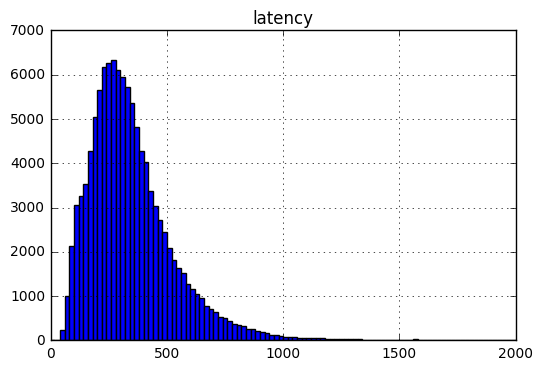

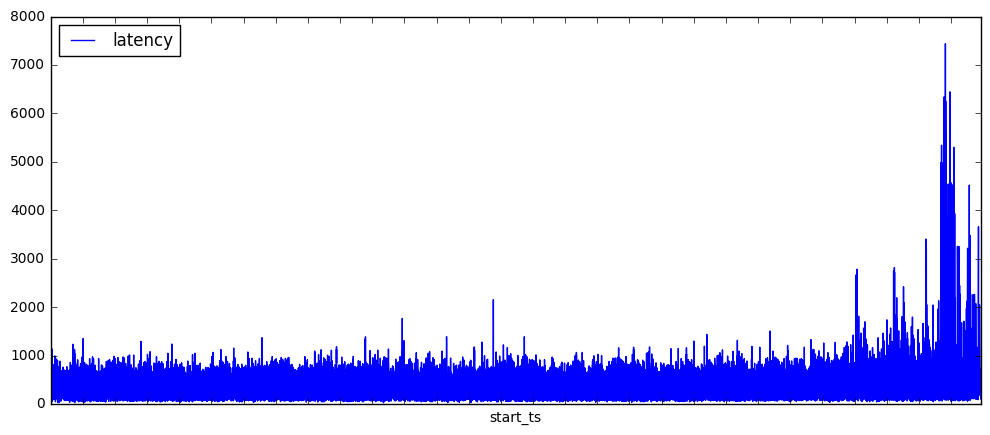

Latency quantile is:


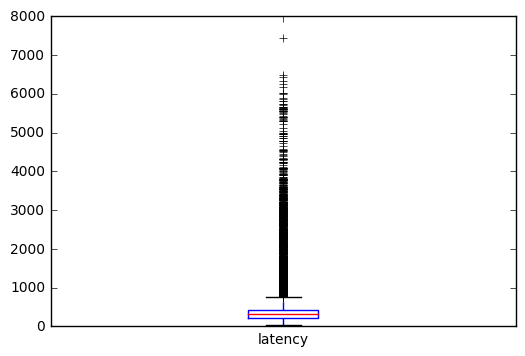

average latency is:
365.602641361
 window size quantile is:


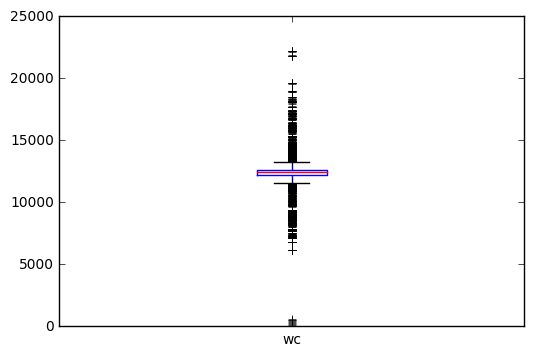

average window size is:
12421.5520182


In [31]:
drawAggregationFigures('/Users/jeka01/Desktop/temp/temp/storm_temp.csv','/Users/jeka01/Desktop/temp/temp/storm_temp',[0,2000],(12,5),100,100)




### Storm 16x, 2 node, 8-4 window, 16384 buffer, 32 parallelism, th_max

Parameters:
- 144K tuples/second Data generation rate and throughout
- Sleep 1 ms for every 10 tuples generated




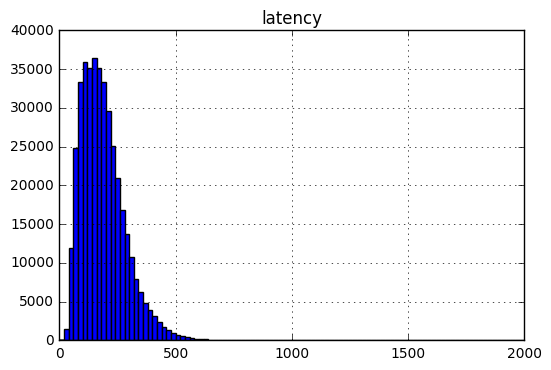

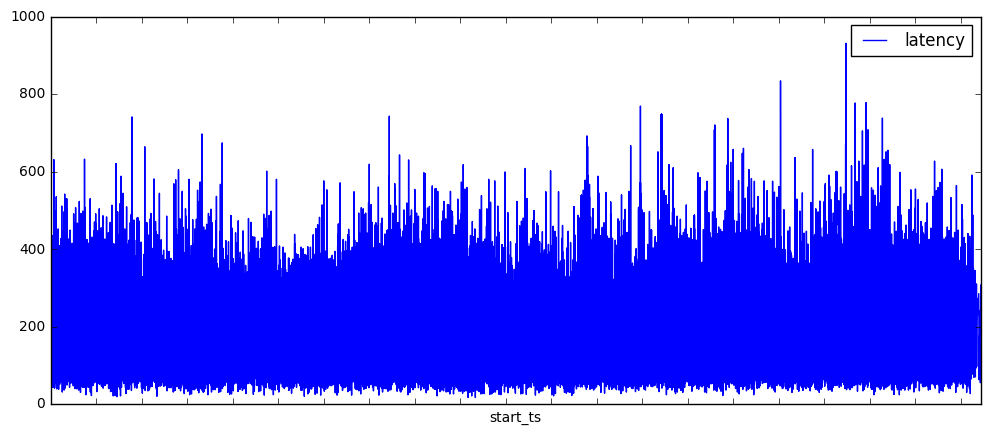

Latency quantile is:


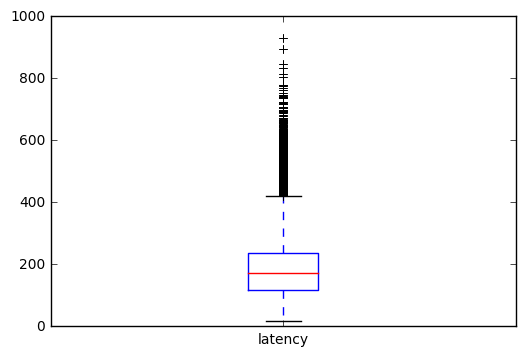

average latency is:
186.594574341
 window size quantile is:


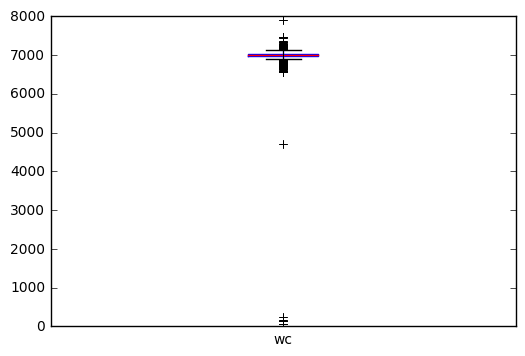

average window size is:
7011.44325789


In [23]:
drawAggregationFigures('../results/storm_agg_2node_th_max.csv','../paper/images/eps/storm_agg_2node_th_max',[0,2000],(12,5),100,100)


### Storm 16x, 2 node, 8-4 window, 16384 buffer, 32 parallelism, th_90

Parameters:
- 128K tuples/second Data generation rate and throughout
- Sleep 1 ms for every 9 tuples generated




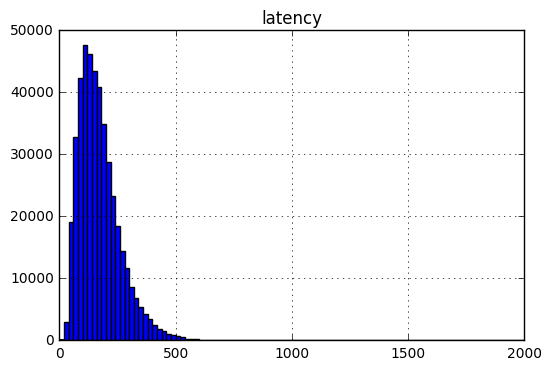

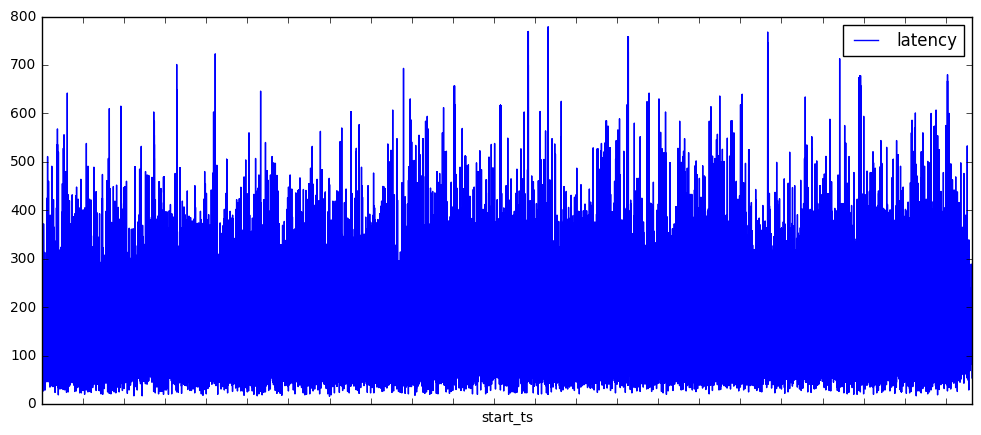

Latency quantile is:


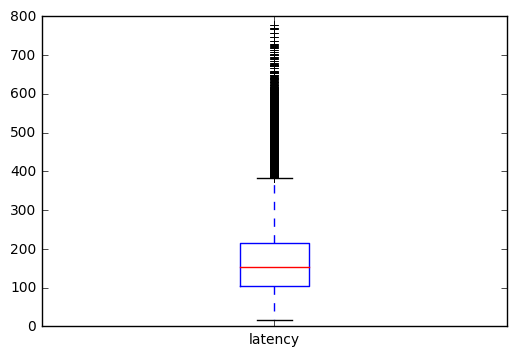

average latency is:
170.45071766
 window size quantile is:


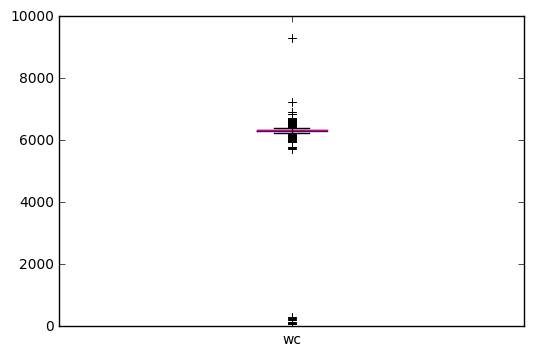

average window size is:
6324.99496123


In [25]:
drawAggregationFigures('../results/storm_agg_2node_th_90.csv','../paper/images/eps/storm_agg_2node_th_90',[0,2000],(12,5),100,100)



### Storm 16x, 3 node, 8-4 window, 16384 buffer, 32 parallelism, th_max

Parameters:
- 248K tuples/second Data generation rate and throughout
- Sleep 1 ms for every 18 tuples generated



### Storm 16x, 3 node, 8-4 window

Parameters:
- 249K tuples/second Data generation rate and throughout
- Sleep 1 ms for every 18 tuples generated




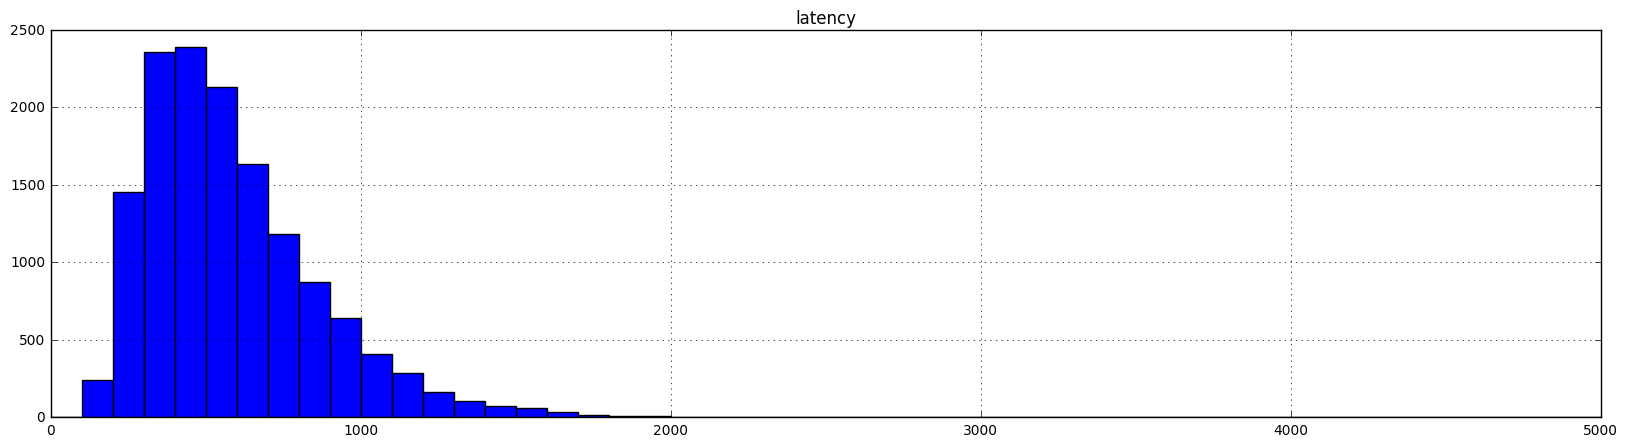

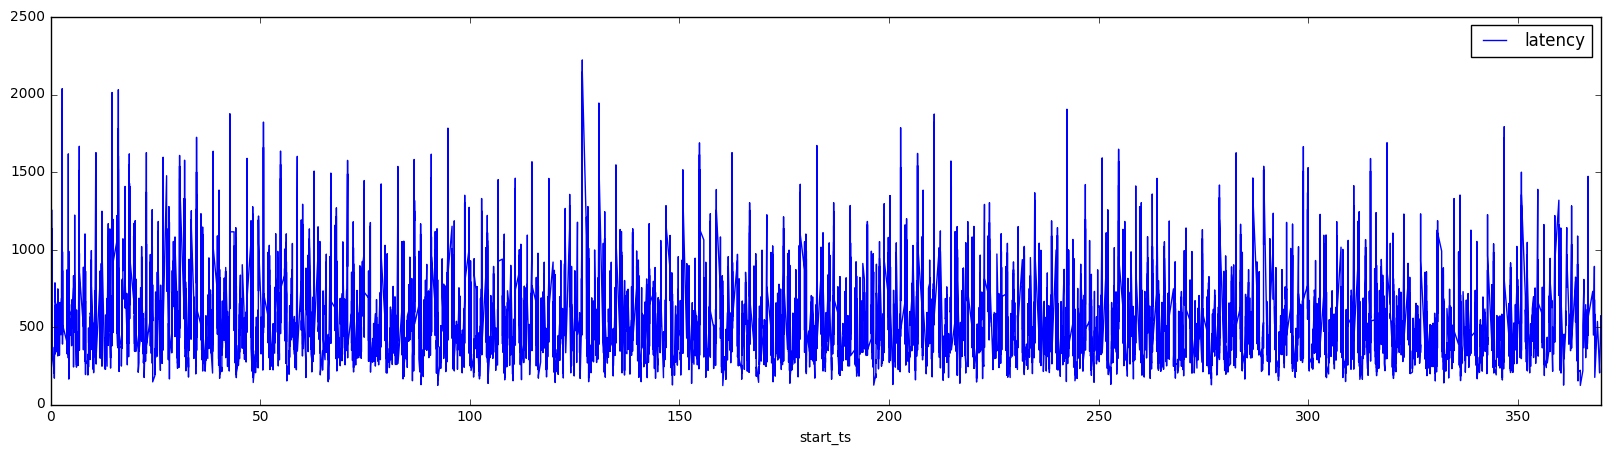

Latency quantile is:


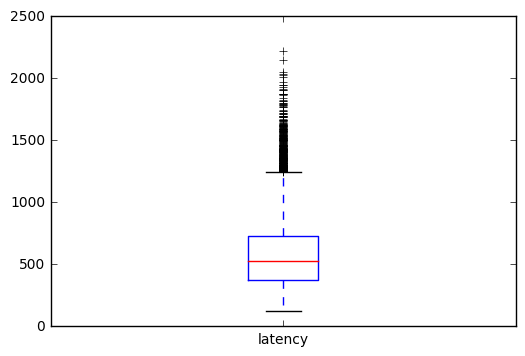

average latency is:
583.151745176
 window size quantile is:


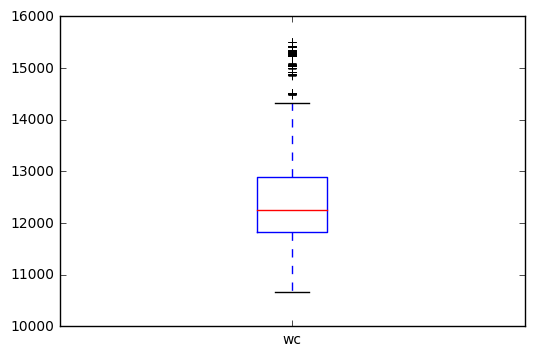

average window size is:
12363.4697077


In [8]:
drawAggregationFigures('/Users/jeka01/Desktop/temp/results/aggregation/storm/3node/16x/8_4/storm_temp.csv',[0,5000],(20,5),50)



### Storm 16x, 4 node, 8-4 window

Parameters:
- 400K tuples/second Data generation rate and throughout
- Sleep 1 ms for every 30 tuples generated




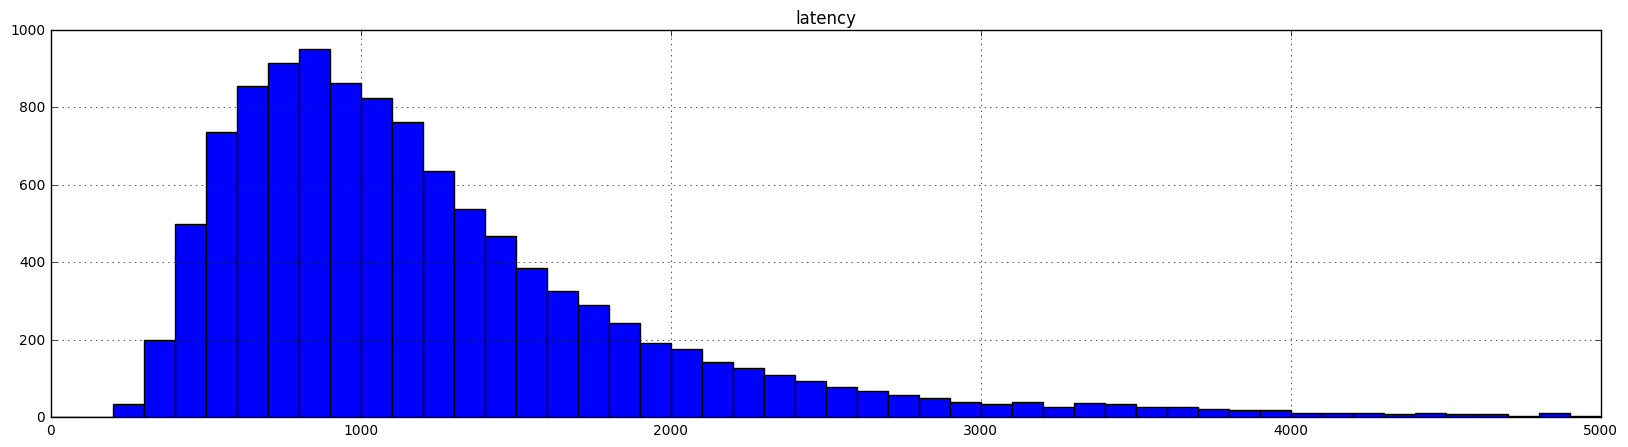

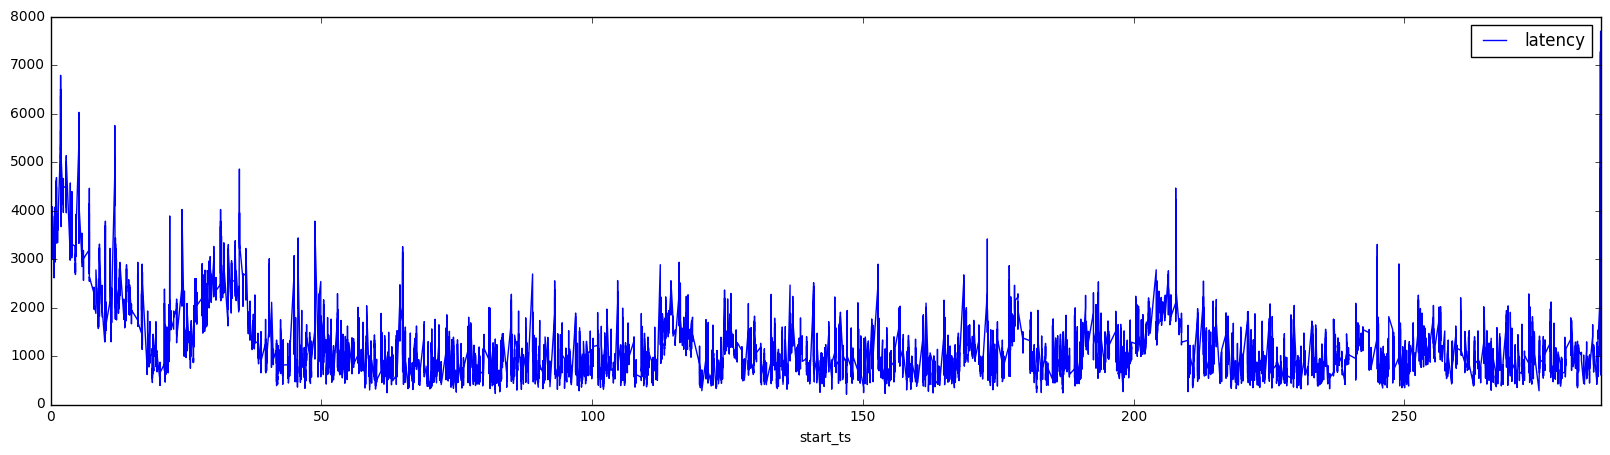

Latency quantile is:


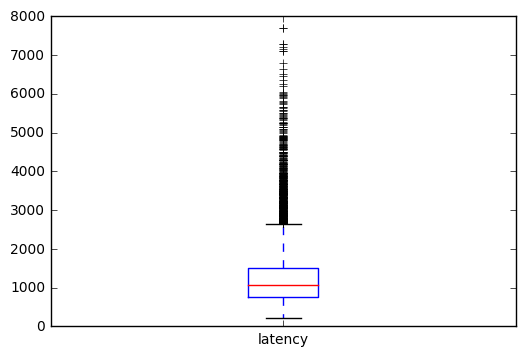

average latency is:
1259.20453727
 window size quantile is:


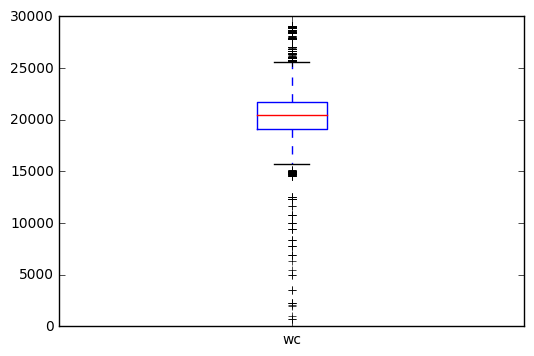

average window size is:
20501.9048434


In [9]:
drawAggregationFigures('/Users/jeka01/Desktop/temp/results/aggregation/storm/4node/16x/8_4/storm_temp.csv',[0,5000],(20,5),50)



### Storm 16x, 8 node, 8-4 window

Parameters:
- 592K tuples/second Data generation rate and throughout
- Sleep 1 ms for every 45 tuples generated





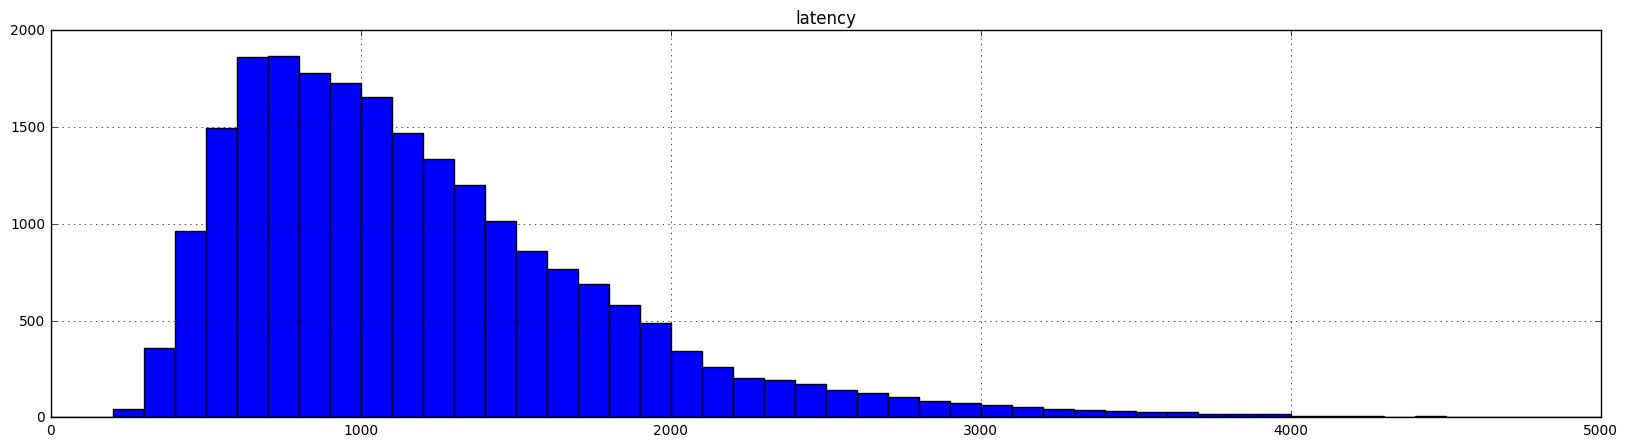

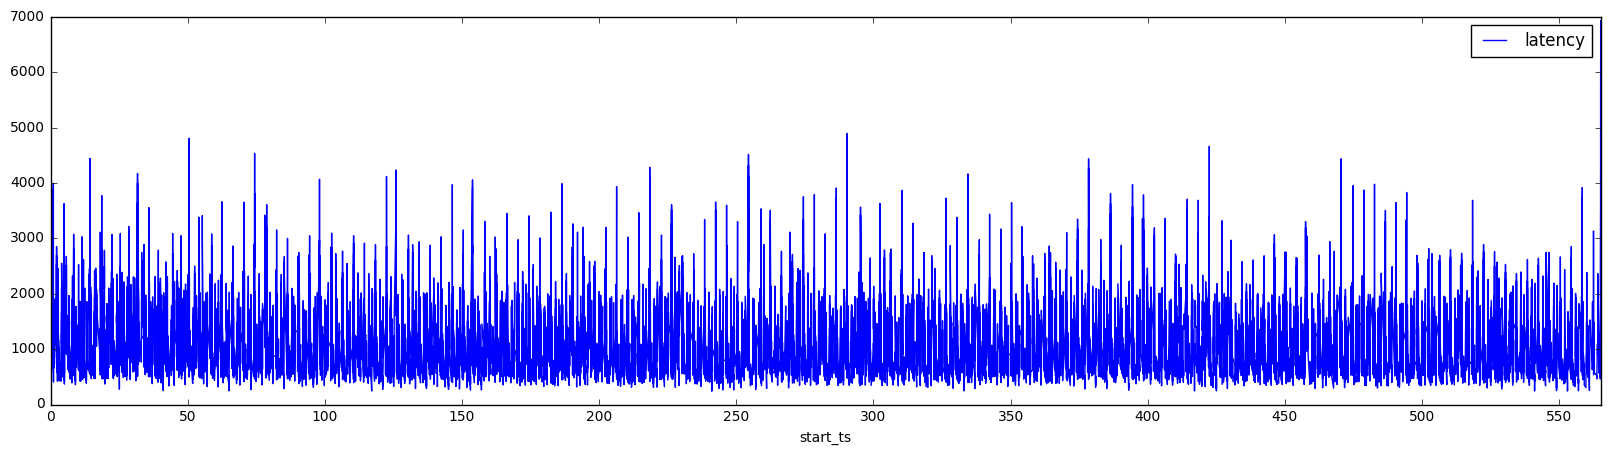

Latency quantile is:


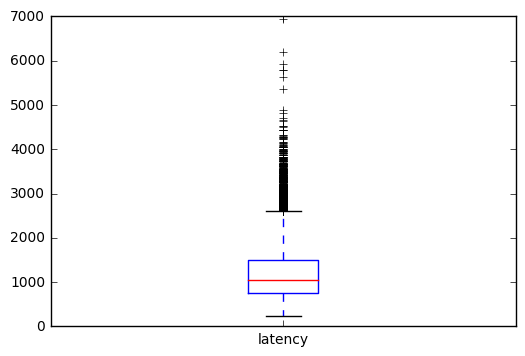

average latency is:
1194.65725335
 window size quantile is:


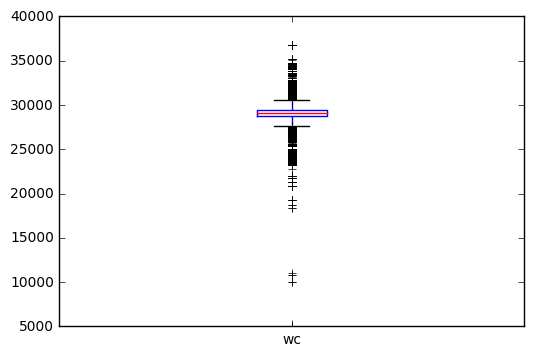

average window size is:
28807.963441


In [10]:
drawAggregationFigures('/Users/jeka01/Desktop/temp/results/aggregation/storm/8node/16x/8_4/storm_temp.csv',[0,5000],(20,5),50)

